<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

This notebook searches the parameter space to create the best possible architecture for our autoencoder and saves the file into a Google Storage Bucket.

In [ ]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 194 (delta 43), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (194/194), 3.86 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/autoencoders_census


In [ ]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [ ]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [ ]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [ ]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)



In [ ]:
original_df.shape

(14765, 305)

In [ ]:
project_data.shape

(14765, 108)

# Transforming the original data set

In [ ]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

# If we want to add indicators for missing values, but we need to also add the appropriate variable types for the missing
# project_data_missing = data_transformer.add_missing_indicators(project_data)
# transformed_df = data_transformer.transform_dataframe(project_data_missing)


In [ ]:
vectorized_df.shape

(14765, 563)

In [ ]:
# This does not work. Need to figure out why.
vectorizer.tabularize_vector(vectorized_df).shape

(14765, 108)

# Autoencoder training

## Hyperparameter search and model training

The training of an autoencoder model while effectively handling missing data with mask variables.

In [ ]:
# Instantiate the class
model = AutoencoderModel()

# Preprocess the data
X_train, X_test = model.split_train_test(vectorized_df)

In [ ]:
# Define the tuner
tuner = model.define_tuner()

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=model.EPOCHS,
             # batch_size=model.BATCH_SIZE,
             validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=model.NUM_TRIALS)[0]
final_model = model.build_autoencoder(best_hps)

Trial 20 Complete [00h 00m 23s]
val_loss: 0.06444705277681351

Best val_loss So Far: 0.06444705277681351
Total elapsed time: 00h 07m 14s


In [ ]:
# Train the final model
history = final_model.fit(X_train, X_train,
                           epochs=5*model.EPOCHS,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/25
329/329 [==============================] - 6s 7ms/step - loss: 0.0833 - val_loss: 0.0672
Epoch 2/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0662 - val_loss: 0.0647
Epoch 3/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0653 - val_loss: 0.0652
Epoch 4/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0648 - val_loss: 0.0654
Epoch 5/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0644 - val_loss: 0.0642
Epoch 6/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0643 - val_loss: 0.0637
Epoch 7/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0640 - val_loss: 0.0646
Epoch 8/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0639 - val_loss: 0.0663
Epoch 9/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0638 - val_loss: 0.0641
Epoch 10/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0638 - val_loss: 0.0630

Visualize the training and validation loss values over epochs.

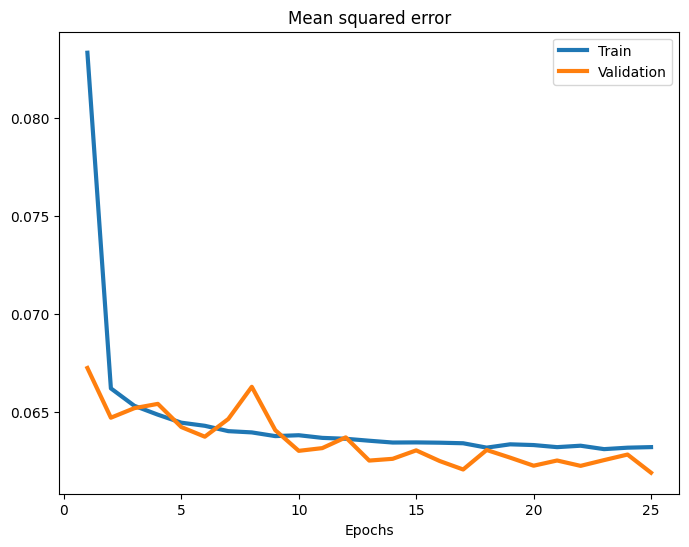

Training MSE = 0.2513822697736363
Validation MSE = 0.24876916656982545


In [ ]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [ ]:
import gcsfs

# Save the model locally
model_filename = "best_parameters_autoencoder.h5"
final_model.save(model_filename)

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder_census')

# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Open the local file in binary mode and upload its content to GCS
with open(model_filename, 'rb') as local_file:
    with fs.open(gcs_model_path, 'wb') as gcs_file:
        gcs_file.write(local_file.read())


In [ ]:


# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "num_epochs": 10,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}